# Libraries 

In [35]:
import math
import os
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import skimage.metrics as metrics
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset

# Data Exploration

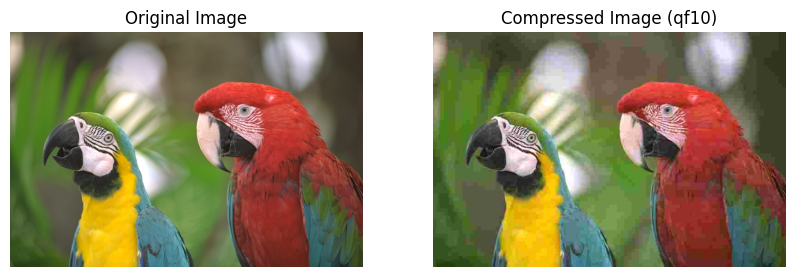

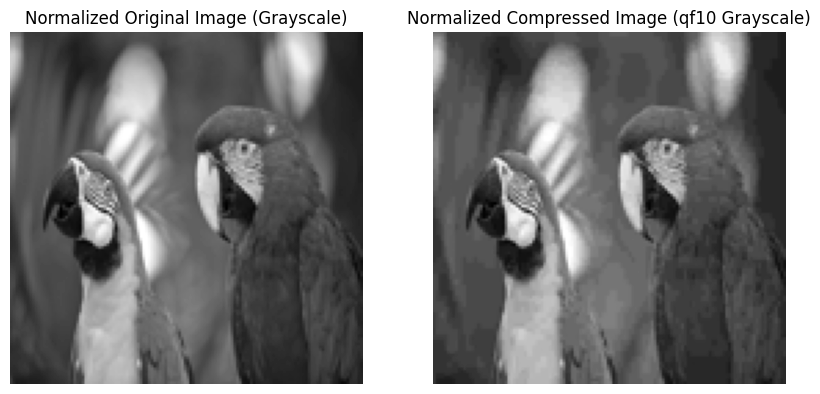

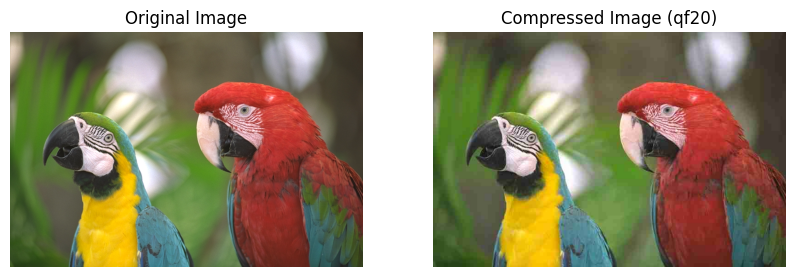

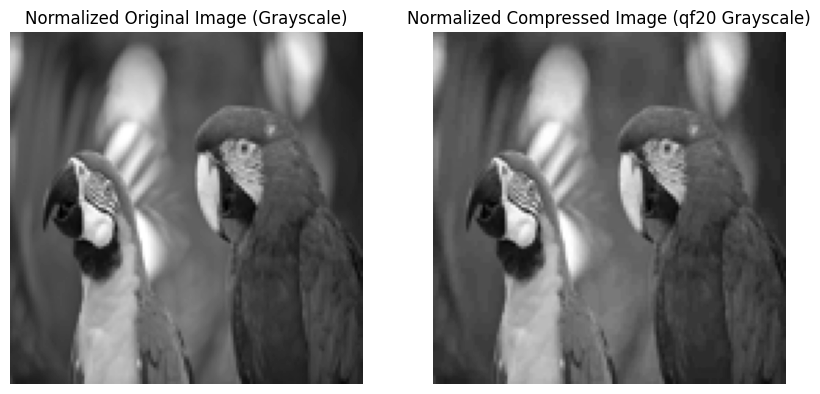

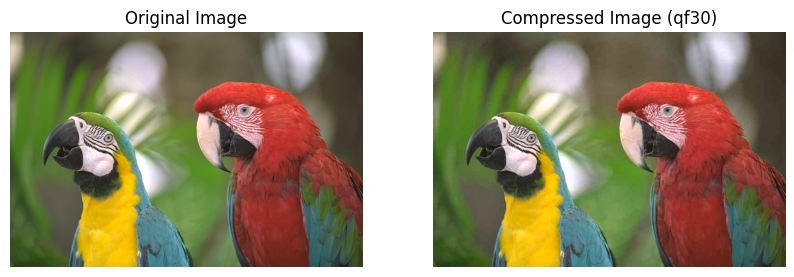

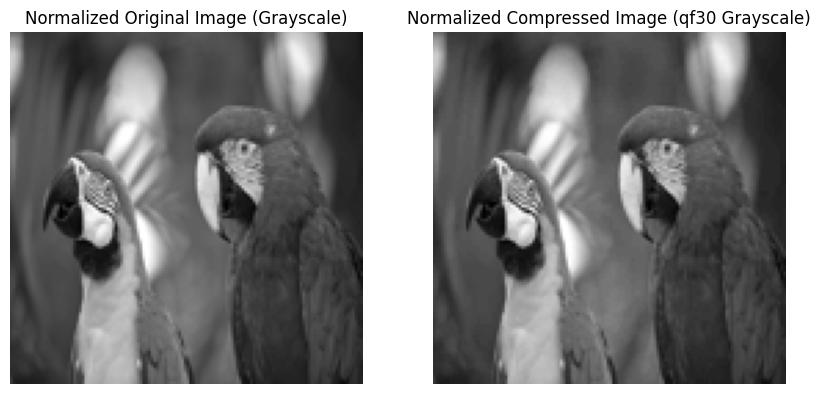

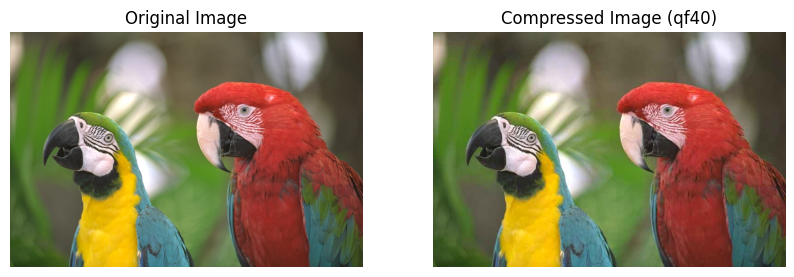

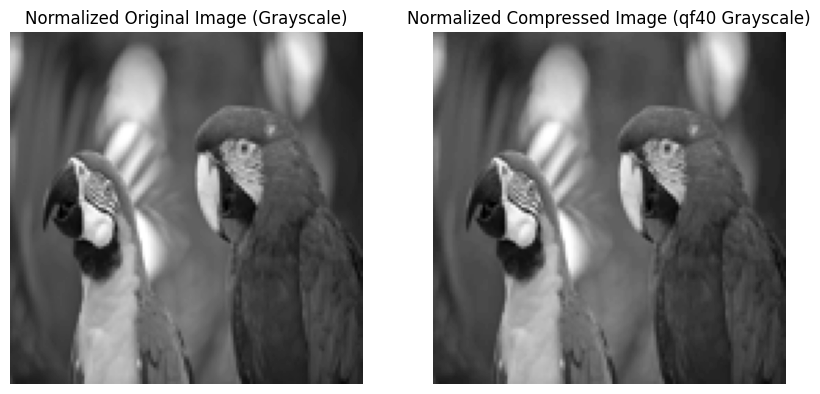

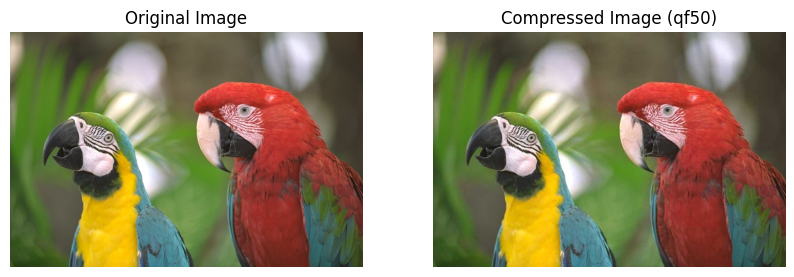

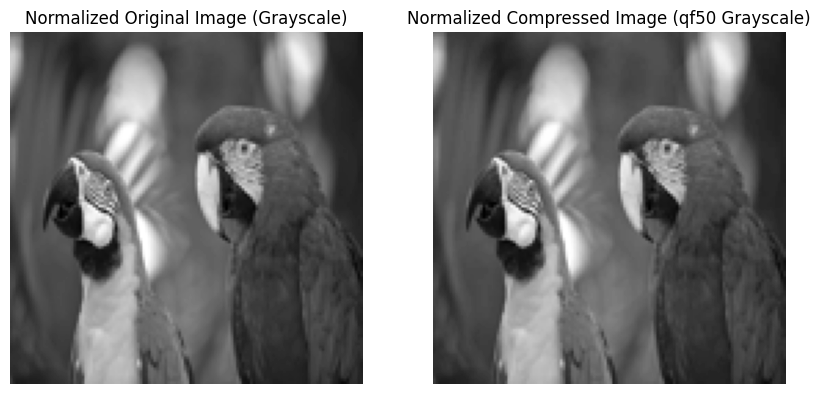

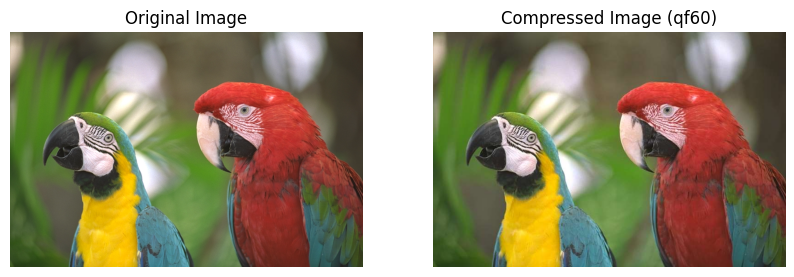

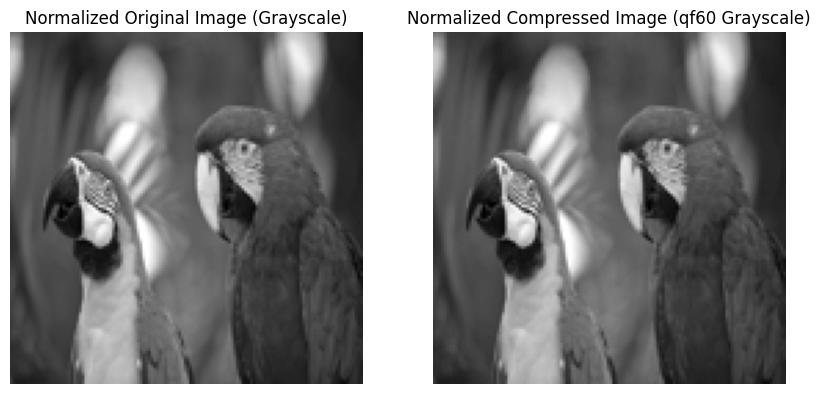

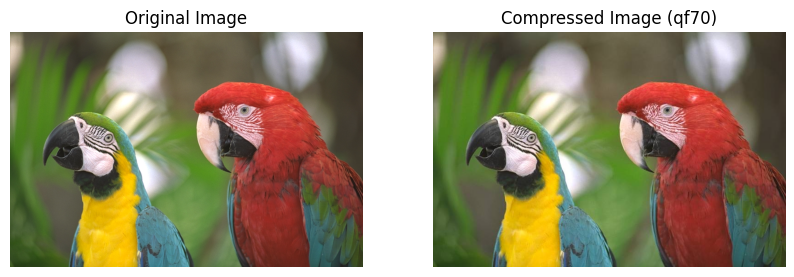

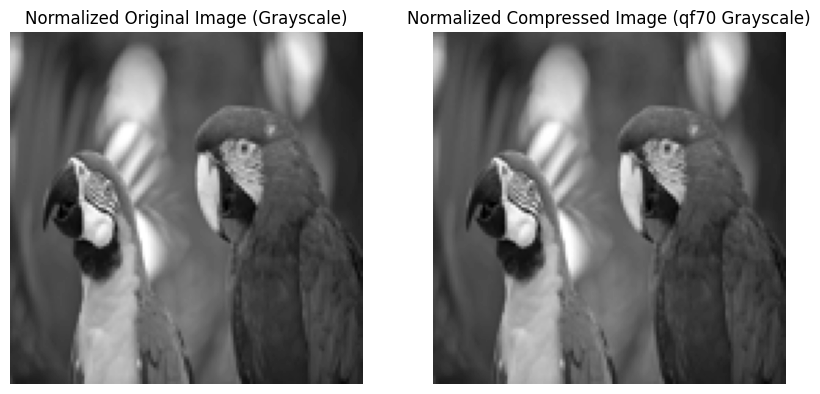

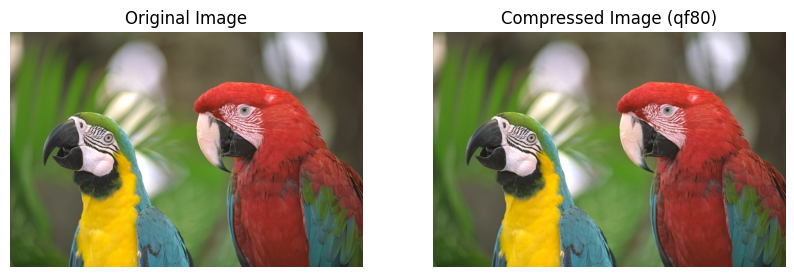

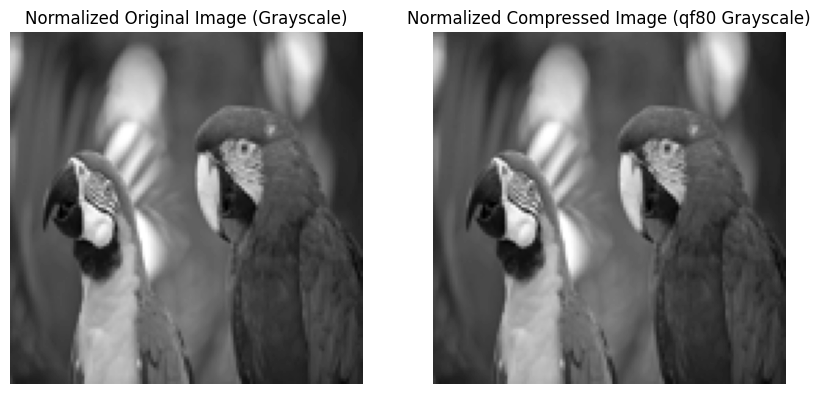

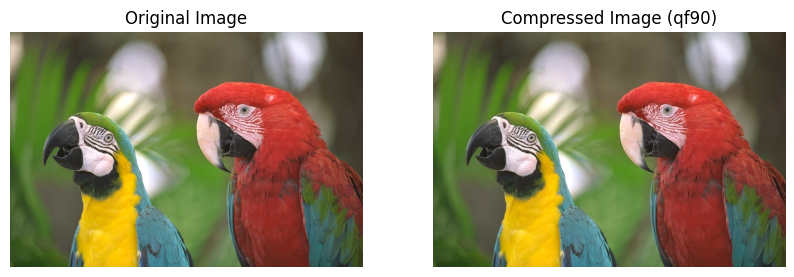

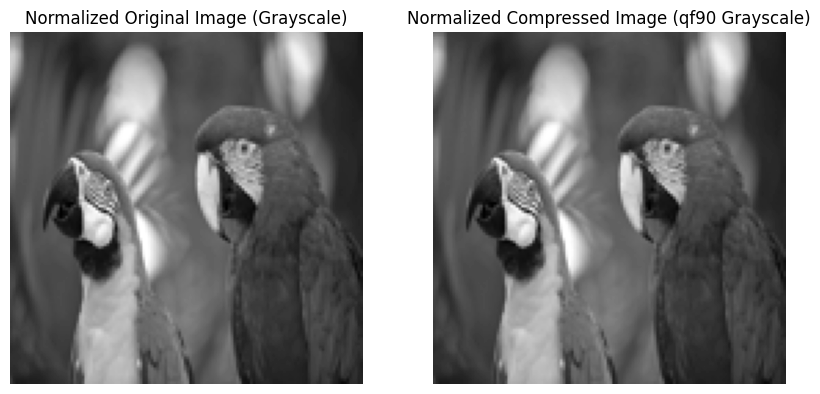

In [36]:
# Helper function to check if a file is an image
def is_image_file(file_name):
    return file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))

# Gathering image files from all quality factor folders
quality_folders = ['qf10', 'qf20', 'qf30', 'qf40', 'qf50', 'qf60', 'qf70', 'qf80', 'qf90']
image_files = {}

# Define the correct path to the extracted images
extract_dir = '/kaggle/input/deep-aa/'

# Iterate over each quality folder
for qf in quality_folders:
    folder_path = os.path.join(extract_dir, qf)
    
    # Collect images from the folder
    image_files[qf] = [f for f in os.listdir(folder_path) if is_image_file(f)]
    
    # Load a sample original image and its compressed version
    refimgs_dir = os.path.join(extract_dir, 'refimgs')
    sample_refimg_path = os.path.join(refimgs_dir, image_files[qf][0])
    sample_qf_img_path = os.path.join(folder_path, image_files[qf][0])

    # Load the images
    ref_image = Image.open(sample_refimg_path)
    compressed_image = Image.open(sample_qf_img_path)

    # Display the images for visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(ref_image)
    axes[0].set_title(f"Original Image")
    axes[0].axis('off')

    axes[1].imshow(compressed_image)
    axes[1].set_title(f"Compressed Image ({qf})")
    axes[1].axis('off')

    plt.show()

    # Convert images to grayscale and resize them to a consistent size (e.g., 128x128)
    image_size = (128, 128)
    ref_image_resized = ref_image.resize(image_size).convert('L')  # Grayscale conversion
    compressed_image_resized = compressed_image.resize(image_size).convert('L')

    # Normalize the image data to [0, 1] range
    ref_image_normalized = np.array(ref_image_resized) / 255.0
    compressed_image_normalized = np.array(compressed_image_resized) / 255.0

    # Display the processed images for comparison
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(ref_image_normalized, cmap='gray')
    axes[0].set_title(f"Normalized Original Image (Grayscale)")
    axes[0].axis('off')

    axes[1].imshow(compressed_image_normalized, cmap='gray')
    axes[1].set_title(f"Normalized Compressed Image ({qf} Grayscale)")
    axes[1].axis('off')

    plt.show()


# CNN for Image Compression

Epoch [1/10], Loss: 0.05735886096954346
Epoch [2/10], Loss: 0.04825986362993717
Epoch [3/10], Loss: 0.03532457002438605
Epoch [4/10], Loss: 0.022870223852805793
Epoch [5/10], Loss: 0.012761860154569149
Epoch [6/10], Loss: 0.010577668435871601
Epoch [7/10], Loss: 0.010054627200588584
Epoch [8/10], Loss: 0.008848685713019222
Epoch [9/10], Loss: 0.008103390573523939
Epoch [10/10], Loss: 0.007769522024318576


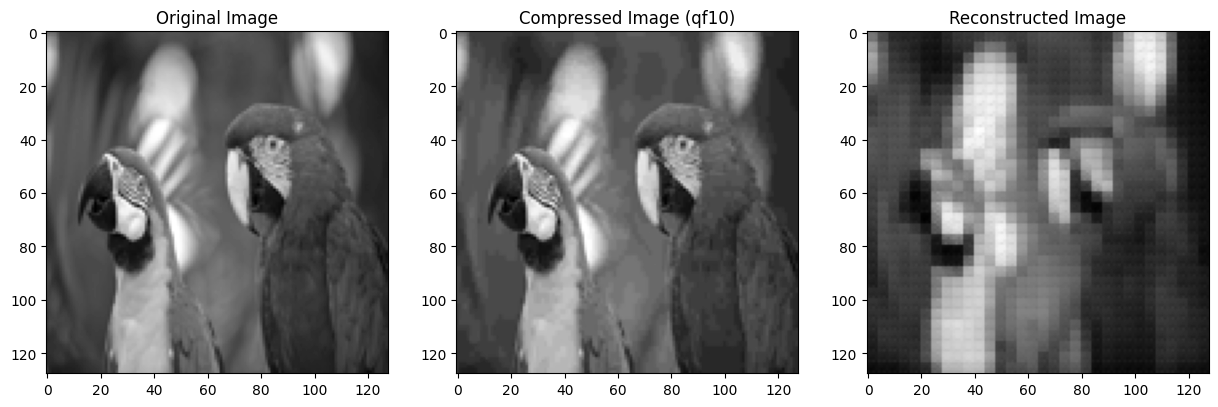

In [38]:
# Helper function to load images and preprocess
def load_and_preprocess_image(image_path, image_size=(128, 128)):
    img = Image.open(image_path).resize(image_size).convert('L')  # Resize and convert to grayscale
    img = np.array(img) / 255.0  # Normalize to [0, 1]
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
    return img

# Custom dataset class for loading images
class ImageCompressionDataset(Dataset):
    def __init__(self, original_dir, compressed_dir, image_size=(128, 128)):
        self.original_dir = original_dir
        self.compressed_dir = compressed_dir
        self.image_files = [f for f in os.listdir(original_dir) if is_image_file(f)]
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        original_image_path = os.path.join(self.original_dir, self.image_files[idx])
        compressed_image_path = os.path.join(self.compressed_dir, self.image_files[idx])
        
        original_image = load_and_preprocess_image(original_image_path, self.image_size)
        compressed_image = load_and_preprocess_image(compressed_image_path, self.image_size)
        
        return original_image, compressed_image

# Define a simple Convolutional Neural Network (CNN) for image compression
class CompressionNet(nn.Module):
    def __init__(self):
        super(CompressionNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # Convolution layer
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),  # Upsample
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2),  # Final output layer
            nn.Sigmoid()  # Output is a normalized image
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CompressionNet().to(device)
criterion = nn.MSELoss()  # Mean squared error for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Prepare dataset and dataloader
dataset = ImageCompressionDataset(original_dir='/kaggle/input/deep-aa/refimgs', 
                                  compressed_dir='/kaggle/input/deep-aa/qf10')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (original_images, compressed_images) in enumerate(dataloader):
        original_images, compressed_images = original_images.to(device), compressed_images.to(device)
        
        optimizer.zero_grad()
        outputs = model(original_images)
        loss = criterion(outputs, compressed_images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader)}')

# Example of evaluation (visualizing the reconstruction for one image)
model.eval()
with torch.no_grad():
    sample_original, sample_compressed = dataset[0]  # Get a sample
    sample_original = sample_original.unsqueeze(0).to(device)
    output = model(sample_original).cpu().squeeze(0)

    # Visualize original, compressed, and reconstructed images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(sample_original.cpu().squeeze(), cmap='gray')  # Remove extra dimension
    ax[0].set_title("Original Image")
    ax[1].imshow(sample_compressed.squeeze(), cmap='gray')  # Remove extra dimension
    ax[1].set_title("Compressed Image (qf10)")
    ax[2].imshow(output.squeeze(), cmap='gray')  # Remove extra dimension
    ax[2].set_title("Reconstructed Image")
    plt.show()


# CNN with Batch Normalization and Dropout

Epoch [1/15], Loss: 0.050495178904384375
Epoch [2/15], Loss: 0.022326381411403418
Epoch [3/15], Loss: 0.017799625173211098
Epoch [4/15], Loss: 0.016316584777086973
Epoch [5/15], Loss: 0.017941289581358433
Epoch [6/15], Loss: 0.01760424068197608
Epoch [7/15], Loss: 0.014659150503575802
Epoch [8/15], Loss: 0.013832875934895128
Epoch [9/15], Loss: 0.014427838730625808
Epoch [10/15], Loss: 0.013789242831990123
Epoch [11/15], Loss: 0.013641996891237795
Epoch [12/15], Loss: 0.01641439035302028
Epoch [13/15], Loss: 0.014556692098267376
Epoch [14/15], Loss: 0.013042544014751911
Epoch [15/15], Loss: 0.014849176863208413


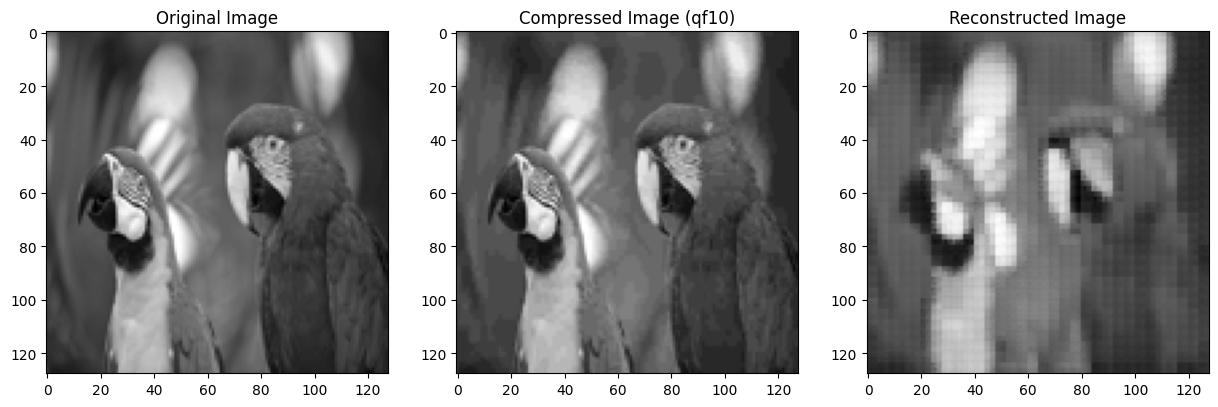

In [13]:
class ImprovedCompressionNet(nn.Module):
    def __init__(self):
        super(ImprovedCompressionNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # Convolution layer
            nn.BatchNorm2d(16),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.MaxPool2d(2, 2),  # Downsample
            nn.Dropout(0.2),  # Dropout

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)  # Dropout
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),  # Upsample
            nn.BatchNorm2d(16),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.Dropout(0.2),  # Dropout
            
            nn.ConvTranspose2d(16, 1, 2, stride=2),  # Final output layer
            nn.Sigmoid()  # Sigmoid activation for normalized output
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate improved model, define loss and optimizer
model = ImprovedCompressionNet().to(device)
criterion = nn.MSELoss()  # Mean squared error for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.009)

# Training loop remains the same
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (original_images, compressed_images) in enumerate(dataloader):
        original_images, compressed_images = original_images.to(device), compressed_images.to(device)
        
        optimizer.zero_grad()
        outputs = model(original_images)
        loss = criterion(outputs, compressed_images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader)}')

# Example of evaluation (visualizing the reconstruction for one image)
model.eval()
with torch.no_grad():
    sample_original, sample_compressed = dataset[0]  # Get a sample
    sample_original = sample_original.unsqueeze(0).to(device)
    output = model(sample_original).cpu().squeeze(0)

    # Visualize original, compressed, and reconstructed images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(sample_original.cpu().squeeze(), cmap='gray')  # Remove extra dimension
    ax[0].set_title("Original Image")
    ax[1].imshow(sample_compressed.squeeze(), cmap='gray')  # Remove extra dimension
    ax[1].set_title("Compressed Image (qf10)")
    ax[2].imshow(output.squeeze(), cmap='gray')  # Remove extra dimension
    ax[2].set_title("Reconstructed Image")
    plt.show()


# Deeper CNN 

Epoch [1/15], Loss: 0.051362084690481424, Learning Rate: [0.007]
Epoch [2/15], Loss: 0.02181697846390307, Learning Rate: [0.007]
Epoch [3/15], Loss: 0.019141116878017783, Learning Rate: [0.007]
Epoch [4/15], Loss: 0.012237410875968635, Learning Rate: [0.007]
Epoch [5/15], Loss: 0.01205299113644287, Learning Rate: [0.0007000000000000001]
Epoch [6/15], Loss: 0.009950502950232476, Learning Rate: [0.0007000000000000001]
Epoch [7/15], Loss: 0.014680359628982842, Learning Rate: [0.0007000000000000001]
Epoch [8/15], Loss: 0.0101767354644835, Learning Rate: [0.0007000000000000001]
Epoch [9/15], Loss: 0.012844834884162992, Learning Rate: [0.0007000000000000001]
Epoch [10/15], Loss: 0.012210847460664809, Learning Rate: [7.000000000000001e-05]
Epoch [11/15], Loss: 0.012946449278388172, Learning Rate: [7.000000000000001e-05]
Epoch [12/15], Loss: 0.014247568266000599, Learning Rate: [7.000000000000001e-05]
Epoch [13/15], Loss: 0.010800588119309396, Learning Rate: [7.000000000000001e-05]
Epoch [14/1

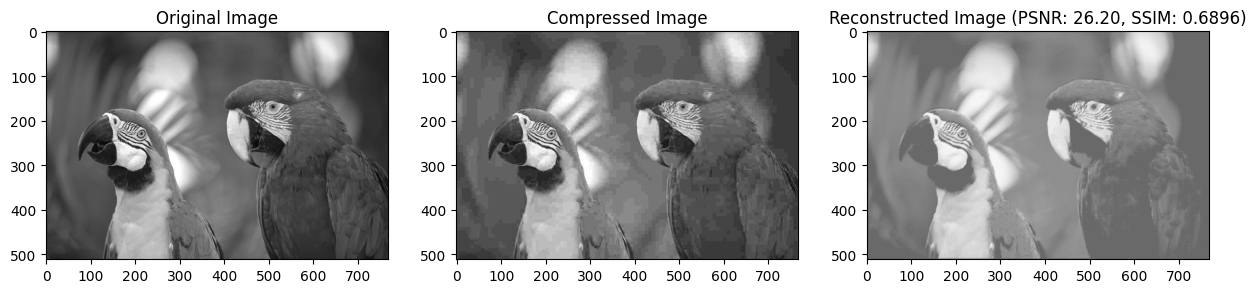

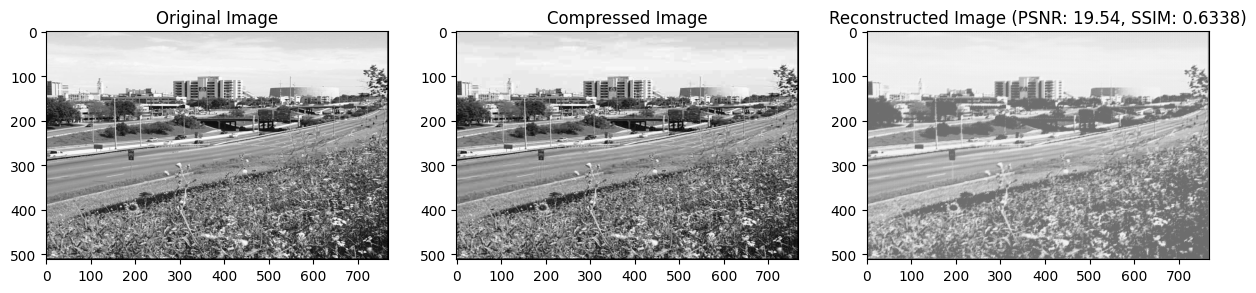

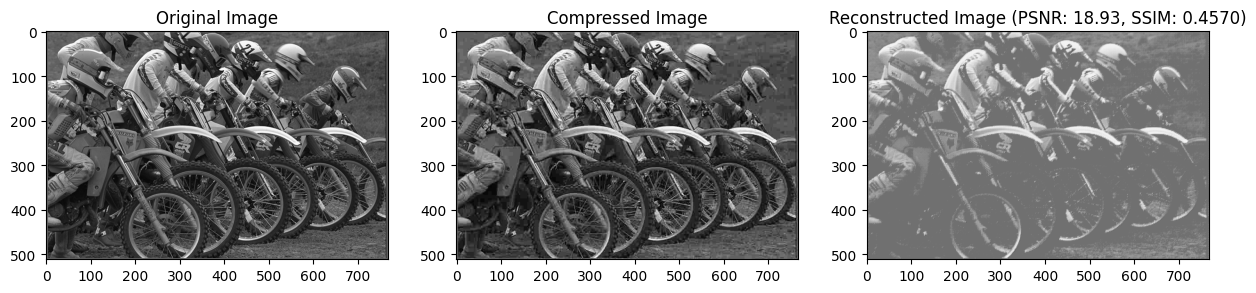

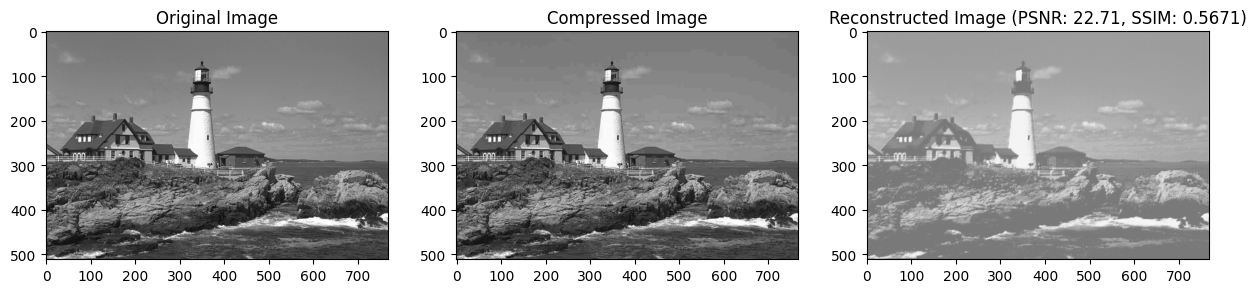

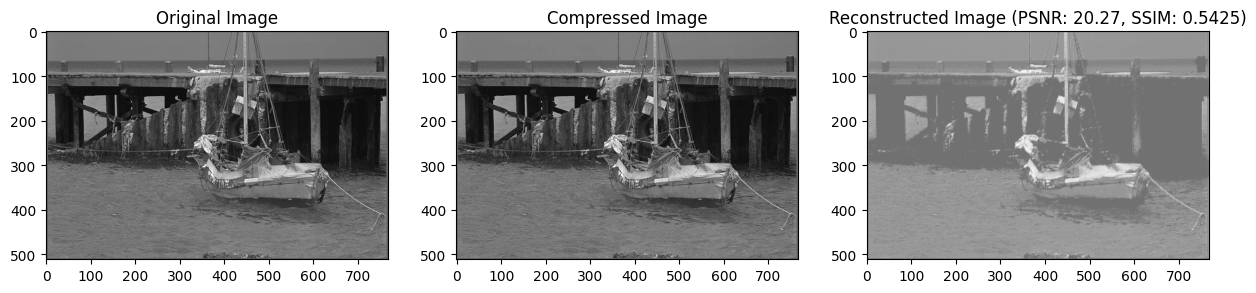

Average PSNR: 21.78
Average SSIM: 0.5965
Model parameters saved successfully.


In [56]:

# Set the random seed for reproducibility
seed = 2
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Helper function to load images and preprocess
def load_and_preprocess_image(image_path, image_size=(256, 256)):
    img = Image.open(image_path).resize(image_size).convert('L')  # Resize and convert to grayscale
    img = np.array(img) / 255.0  # Normalize to [0, 1]
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
    return img

# Custom dataset class for loading images from multiple quality factor folders
class ImageCompressionDataset(Dataset):
    def __init__(self, original_dir, compressed_dirs, image_size=(768, 512)):
        self.original_dir = original_dir
        self.compressed_dirs = compressed_dirs  # List of directories for qf10, qf20, ..., qf90
        self.image_files = [f for f in os.listdir(original_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        original_image_path = os.path.join(self.original_dir, self.image_files[idx])
        compressed_dir = np.random.choice(self.compressed_dirs)  # Randomly choose a compression level
        compressed_image_path = os.path.join(compressed_dir, self.image_files[idx])
        
        original_image = load_and_preprocess_image(original_image_path, self.image_size)
        compressed_image = load_and_preprocess_image(compressed_image_path, self.image_size)
        
        return original_image, compressed_image

# Define a deeper Convolutional Neural Network (CNN) with Batch Normalization, Dropout, and Skip Connections
class SkipCompressionNet(nn.Module):
    def __init__(self):
        super(SkipCompressionNet, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_pool1 = nn.MaxPool2d(2, 2)
        
        self.enc_conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_pool2 = nn.MaxPool2d(2, 2)
        
        self.enc_conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(128)
        self.enc_pool3 = nn.MaxPool2d(2, 2)

        # Decoder with skip connections
        
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec_bn1 = nn.BatchNorm2d(64)
        
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec_bn2 = nn.BatchNorm2d(32)
        
        self.dec_conv3 = nn.ConvTranspose2d(32, 1, 2, stride=2)
        
        self.final_conv = nn.Conv2d(1, 1, 3, padding=1)
        self.activation = nn.Tanh()  # Changed final activation

    def forward(self, x):
        # Encoder with saved feature maps for skip connections
        enc1 = self.enc_pool1(F.relu(self.enc_bn1(self.enc_conv1(x))))
        enc2 = self.enc_pool2(F.relu(self.enc_bn2(self.enc_conv2(enc1))))
        enc3 = self.enc_pool3(F.relu(self.enc_bn3(self.enc_conv3(enc2))))
        
        # Decoder with skip connections
        dec1 = F.relu(self.dec_bn1(self.dec_conv1(enc3)))
        dec2 = F.relu(self.dec_bn2(self.dec_conv2(dec1 + enc2)))  # Skip connection
        dec3 = F.relu(self.dec_conv3(dec2 + enc1))  # Skip connection
        
        out = self.activation(self.final_conv(dec3))
        return out

# Helper function to compute PSNR
def calculate_psnr(original, reconstructed):
    original = original.to(reconstructed.device)
    mse = nn.MSELoss()(original, reconstructed).item()
    if mse == 0:
        return 100  # Perfect reconstruction
    max_pixel = 1.0  # Normalized images, max pixel value is 1.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

# Helper function to compute SSIM
def calculate_ssim(original, reconstructed):
    original_np = original.squeeze().cpu().numpy()
    reconstructed_np = reconstructed.squeeze().cpu().numpy()
    ssim = metrics.structural_similarity(original_np, reconstructed_np, data_range=original_np.max() - original_np.min())
    return ssim

# Instantiate the deeper model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkipCompressionNet().to(device)
criterion = nn.MSELoss()  # Mean squared error for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.007)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Prepare dataset and dataloader
compressed_dirs = ['/kaggle/input/deep-aa/qf10', '/kaggle/input/deep-aa/qf20', '/kaggle/input/deep-aa/qf30', 
                   '/kaggle/input/deep-aa/qf40', '/kaggle/input/deep-aa/qf50', '/kaggle/input/deep-aa/qf60', 
                   '/kaggle/input/deep-aa/qf70', '/kaggle/input/deep-aa/qf80', '/kaggle/input/deep-aa/qf90']

dataset = ImageCompressionDataset(original_dir='/kaggle/input/deep-aa/refimgs', compressed_dirs=compressed_dirs)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, worker_init_fn=lambda _: np.random.seed(seed))

# Training loop
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (original_images, compressed_images) in enumerate(dataloader):
        original_images, compressed_images = original_images.to(device), compressed_images.to(device)
        
        optimizer.zero_grad()
        outputs = model(original_images)
        loss = criterion(outputs, compressed_images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Adjust the learning rate at the end of each epoch
    scheduler.step()

    # print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader)}')
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader)}, Learning Rate: {scheduler.get_last_lr()}")
# Example of evaluation (PSNR, SSIM, visual inspection)
model.eval()
with torch.no_grad():
    total_psnr = 0
    total_ssim = 0
    num_images = 0

    # Iterate over the entire dataset
    for idx in range(len(dataset)):
        original_image, compressed_image = dataset[idx]
        original_image = original_image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        reconstructed_image = model(original_image).cpu().squeeze(0)  # Reconstructed image moved to CPU

        # Calculate PSNR
        psnr = calculate_psnr(original_image.cpu(), reconstructed_image)
        total_psnr += psnr

        # Calculate SSIM
        ssim = calculate_ssim(original_image.cpu(), reconstructed_image)
        total_ssim += ssim

        num_images += 1

        # Visualize original, compressed, and reconstructed images for first 5 images
        if idx < 5:
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(original_image.cpu().squeeze(), cmap='gray')
            ax[0].set_title("Original Image")
            ax[1].imshow(compressed_image.squeeze(), cmap='gray')
            ax[1].set_title("Compressed Image")
            ax[2].imshow(reconstructed_image.squeeze(), cmap='gray')
            ax[2].set_title(f"Reconstructed Image (PSNR: {psnr:.2f}, SSIM: {ssim:.4f})")
            plt.show()

    # Compute average PSNR and SSIM
    avg_psnr = total_psnr / num_images
    avg_ssim = total_ssim / num_images

    print(f"Average PSNR: {avg_psnr:.2f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

# Save model parameters after training
torch.save(model.state_dict(), "image_compression_model.pth")
print("Model parameters saved successfully.")